## Purpose
The purpose of this application is to inspect the prostate dataset that we intend
to use for the project in 02450 Intro to Machine Learning

Author: Greta Tuckute
Reviewed by: 
Last modified: 28/010/18, 09.09

#### Change-log


Import required packages

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from scipy.linalg import svd
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show, clim, hist
import sklearn.linear_model as lm
import os


First we define a method for importing a spread_sheet using pandas

In [53]:
def DataLoader(path, sheet):
    """
    Method for importing data from a spreadsheet.

    :param path: full path to the spreadsheet to load
    :param sheet: name of the sheet in the workbook that is loaded
    :return: pandas dataFrame with imported data
    """
    import pandas as pd

    out = pd.read_excel(path, sheet_name=sheet)

    return out

In [54]:
# Specify path and sheet name in the prostate workbook
#filePath = 'C:/Users/PeterBakke/Documents/git/ML_fall2018/Data/Prostate.xlsx'
filePath = 'C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/narisa/Documents/GitHub/ML_fall2018/Data/Prostate.xlsx'
sheet = 'Sheet1'

In [101]:
# Load prostate data into dataFrame
myData = DataLoader(path=filePath, sheet=sheet)

# delete irrelevant columns
del myData['ID']
del myData['train']


### Data feature extraction and normalization

In [102]:
# If we apply one out of K encoding to Gleason/PGG45, we assume that a higher value is not informative of disease result?

# Usually done for ordinal (not often for nominal)

# Do NOT normalise categorical data

In [103]:
# Extract class names 
attributeNames = list(myData.columns.values)

# Convert dataFrame to numpy array
X = myData.values

# Compute values of N (observations) and M (features)
M = len(attributeNames)
N = X.shape[0]

print(attributeNames)

['lCaVol', 'lWeight', 'Age', 'lBPH', 'SVI', 'lCP', 'Gleason', 'pgg45', 'lPSA']


In [104]:
# Extracting and deleting PGG45 and Gleason from X, as well as SVI (to not normalize SVI)
X_orig = np.copy(X)

gleason = X_orig[:,6]
pgg = X_orig[:,7]
svi = X_orig[:,4]

# print(X)

In [105]:
# OBS - only run this once
X = np.delete(X,6,1) # Deletes Gleason
X = np.delete(X,6,1) # Deletes PGG
X = np.delete(X,4,1) # Deletes SVI

In [106]:
print(X.shape)
# print(X)

(97, 6)


In [107]:
# Z score all other variables 
X_z = zscore(X)
# print(X_z)

# Current order: lCavol, lWeight, Age, lBPH, lCP, lPSA

In [108]:
# One out of K coding for PGG and Gleason

from categoric2numeric import *

[X_Gleason, attribute_names_Gleason]=categoric2numeric(gleason)
[X_PGG45, attribute_names_PGG45]=categoric2numeric(pgg)

#print(X_Gleason)

In [129]:
print(X_PGG45.shape)
print(np.unique(pgg))
print(svi.shape)
print(X_Gleason.shape)

# 97*30

(97, 19)
[  0.   4.   5.   6.  10.  15.  20.  25.  30.  35.  40.  50.  60.  70.
  75.  80.  90.  95. 100.]
(97,)
(97, 4)


In [161]:
# Add one out of K coded Gleason and PGG columns, as well as SVI 
svi = np.reshape(svi,[97,1])
print(svi.shape)
# X_k = np.concatenate((X,X_Gleason,X_PGG45,svi),axis=1)
X_k = np.concatenate((X,X_Gleason,svi),axis=1)

print(X_k.shape)
print(X_k[2])

# Order: lCavol, lWeight, Age, lBPH, lCP, lPSA, Gleason (4 columns), (PGG (19 columns)), SVI (1 column)


(97, 1)
(97, 11)
[-0.51082562  2.691243   74.         -1.38629436 -1.38629436 -0.1625189
  0.          1.          0.          0.          0.        ]


### Regression section

In [162]:
# Split dataset into features and target vector
lPSA_idx = 5
# Test lPSA idx:
print(X_k[:,5])

[-0.4307829 -0.1625189 -0.1625189 -0.1625189  0.3715636  0.7654678
  0.7654678  0.8544153  1.047319   1.047319   1.2669476  1.2669476
  1.2669476  1.3480731  1.3987169  1.446919   1.4701758  1.4929041
  1.5581446  1.5993876  1.6389967  1.6582281  1.6956156  1.7137979
  1.7316555  1.7664417  1.8000583  1.8164521  1.8484548  1.8946169
  1.9242487  2.008214   2.008214   2.0215476  2.0476928  2.0856721
  2.1575593  2.1916535  2.2137539  2.2772673  2.2975726  2.3075726
  2.3272777  2.3749058  2.5217206  2.5533438  2.5687881  2.5687881
  2.5915164  2.5915164  2.6567569  2.677591   2.6844403  2.6912431
  2.7047113  2.7180005  2.7880929  2.7942279  2.8063861  2.8124102
  2.8419982  2.8535925  2.8535925  2.8820035  2.8820035  2.8875901
  2.9204698  2.9626924  2.9626924  2.9729753  3.0130809  3.0373539
  3.0563569  3.0750055  3.2752562  3.3375474  3.3928291  3.4355988
  3.4578927  3.5130369  3.5160131  3.5307626  3.5652984  3.5709402
  3.5876769  3.6309855  3.6800909  3.7123518  3.9843437  3.993

In [163]:
y = X_k[:,lPSA_idx] # Extracting the y-label (lPSA)

X_cols = list(range(0,lPSA_idx)) + list(range(lPSA_idx+1,(X_k.shape[1])))
X1 = X_k[:,X_cols] # The new data array without lPSA

print(X1.shape)
print(X1[0])


(97, 10)
[-0.5798185   2.769459   50.         -1.38629436 -1.38629436  1.
  0.          0.          0.          0.        ]


In [164]:
# Creating a new, manual attributeNames for later use
print(attribute_names_Gleason)
print(attribute_names_PGG45)

attributeNamesNew = ['lCaVol', 'lWeight', 'Age', 'lBPH', 'lCP','Gleason 6.0', 'Gleason 7.0', 'Gleason 8.0', 'Gleason 9.0','SVI']


['6.0', '7.0', '8.0', '9.0']
['0.0', '4.0', '5.0', '6.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0', '50.0', '60.0', '70.0', '75.0', '80.0', '90.0', '95.0', '100.0']


Mean squared error: 0.4366786993607977


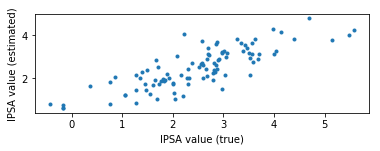

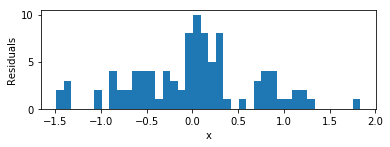

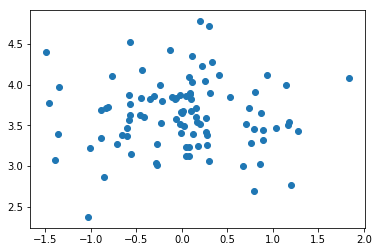

In [165]:
# Fit ordinary least squares regression model - NOT NORMALIZED/FEATURE ENCODED DATA
model = lm.LinearRegression()
model.fit(X1,y)

# Predict lPSA 
y_est = model.predict(X1)
residual = y_est-y

# Mean squared error
mse = (sum(residual**2))/len(residual)
print('Mean squared error: ' + str(mse))

# Display scatter plot
figure(1)
subplot(2,1,1)
plot(y, y_est, '.')
xlabel('lPSA value (true)'); ylabel('lPSA value (estimated)');

figure(2)
subplot(2,1,2)
hist(residual,40)
xlabel('x'); ylabel('Residuals');

show()

lWeight = X1[:,1]

plt.scatter(residual,lWeight)

In [10]:
# We observe that it does not seem necessary to add a term with higher polynomials (based on the true vs estimated plot?)


In [122]:
# Should we add more terms on the linear regression model? Ex 5.2.3

In [123]:
# Parameters
# Km = 2  # no of terms for regression model

# # Fit ordinary least squares regression model
# Xm = np.power(X1, range(1,Km+1))
# model2 = lm.LinearRegression()
# model2 = model2.fit(Xm,y)

# # Predict values
# Xme = np.power(Xe, range(1,Km+1))
# y_est = model.predict(Xme)

### Forward selection

C:\Users\Greta\Documents\GitHub\ML_fall2018
Cross validation fold 1/5
Train indices: [ 0  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26
 27 29 31 32 34 35 36 37 39 41 42 43 45 47 48 50 51 52 53 54 55 57 58 59
 60 61 62 63 65 66 68 72 73 74 75 77 78 79 80 81 82 83 85 86 87 88 89 91
 92 93 94 95 96]
Test indices: [ 1 10 22 28 30 33 38 40 44 46 49 56 64 67 69 70 71 76 84 90]
Features no: 4

Cross validation fold 2/5
Train indices: [ 1  2  3  4  5  6  8 10 11 12 13 16 17 18 19 20 21 22 23 25 26 27 28 29
 30 32 33 34 35 36 38 39 40 42 44 45 46 48 49 50 51 52 53 54 55 56 58 60
 61 63 64 65 67 68 69 70 71 72 73 75 76 77 78 79 80 82 83 84 85 87 90 91
 92 93 94 95 96]
Test indices: [ 0  7  9 14 15 24 31 37 41 43 47 57 59 62 66 74 81 86 88 89]
Features no: 5

Cross validation fold 3/5
Train indices: [ 0  1  3  4  6  7  9 10 12 13 14 15 16 20 22 23 24 26 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 49 50 51 52 53 54 56 57 58 59
 60 61 62 64 65 66 67 68 69 70 

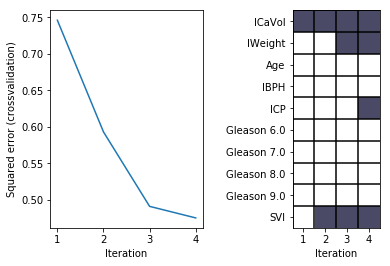

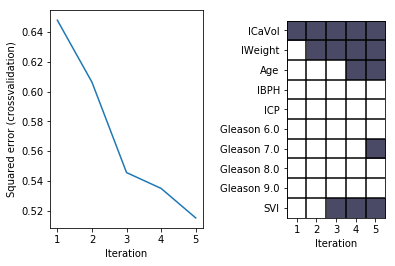

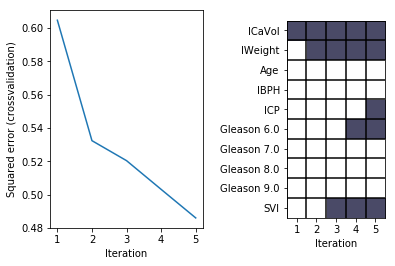

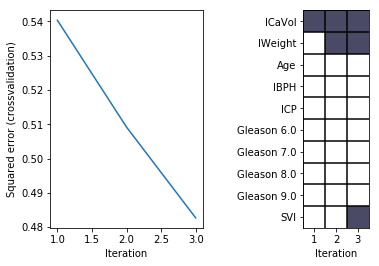

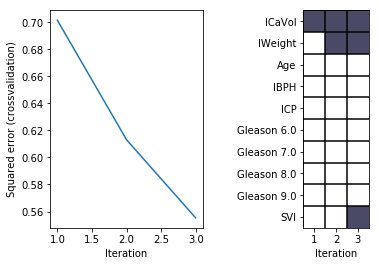

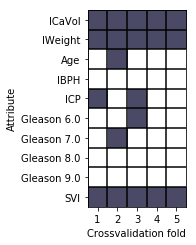

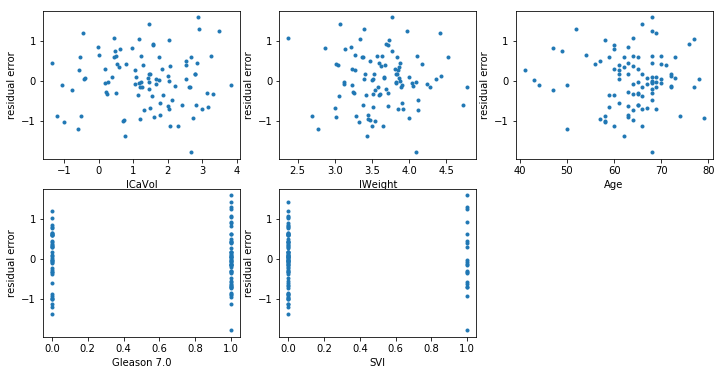

In [166]:
# Forward selection imports
print(os.getcwd())
#os.chdir('C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'

from sklearn import model_selection
from toolbox_02450 import feature_selector_lr, bmplot

N, M = X1.shape

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X1):
    
    # extract training and test set for current CV fold
    X_train = X1[train_index,:]
    y_train = y[train_index]
    X_test = X1[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    #textout = 'verbose';
    textout = '';
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k]=1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) is 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNamesNew, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))
    k += 1
    
    # Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNamesNew, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) is 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X1[:,ff], y)
    
    y_est= m.predict(X1[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2,np.ceil(len(ff)/2.0),i+1)
       plot(X1[:,ff[i]],residual,'.')
       xlabel(attributeNamesNew[ff[i]])
       ylabel('residual error')
    
    
    show()
    